# Disclaimer
### **This notebook is made for research purposes and should not be taken as advice for any financial action!

In this project we want to predict Tesla's stock price using 3 different learning objectives, Lstm, Arima and Prophet.


## Data

In [67]:
import pandas as pd
from stock_prediction.yfinance_data import StockData
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from keras.metrics import MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [161]:
tsla = StockData(symbol='TSLA', start_date="2020-01-01", end_date="2024-01-01")
data = tsla.get_historical_symbol_data().reset_index()
data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Adj Close,Open,High,Low,Close,Volume
0,2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500
1,2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500
2,2020-01-06,30.10,29.36,30.10,29.33,30.10,151995000
3,2020-01-07,31.27,30.76,31.44,30.22,31.27,268231500
4,2020-01-08,32.81,31.58,33.23,31.22,32.81,467164500


In [94]:
data.shape

(918, 7)

In [95]:
data.describe()

,Date,Adj Close,Open,High,Low,Close,Volume
count,918,918.000000,918.000000,918.000000,918.000000,918.000000,9.180000e+02
mean,2021-10-27 15:50:35.294117632,205.903867,206.007876,210.757843,200.830817,205.903867,1.344281e+08
min,2020-01-02 00:00:00,24.080000,24.980000,26.990000,23.370000,24.080000,2.940180e+07
25%,2020-11-27 18:00:00,145.010000,146.237500,149.145000,141.567500,145.010000,7.431435e+07
50%,2021-10-26 12:00:00,218.920000,219.430000,223.205000,213.350000,218.920000,1.035735e+08
75%,2022-09-25 06:00:00,266.860000,267.870000,273.102500,261.127500,266.860000,1.668689e+08
max,2023-08-24 00:00:00,409.970000,411.470000,414.500000,405.670000,409.970000,9.140820e+08
std,NaN,88.980931,89.203160,90.993551,87.061534,88.980931,9.255173e+07


### As we can see the price has significantly risen over the past few years
### Our first learning objective will be Arima Model, so lets see if this method could be be

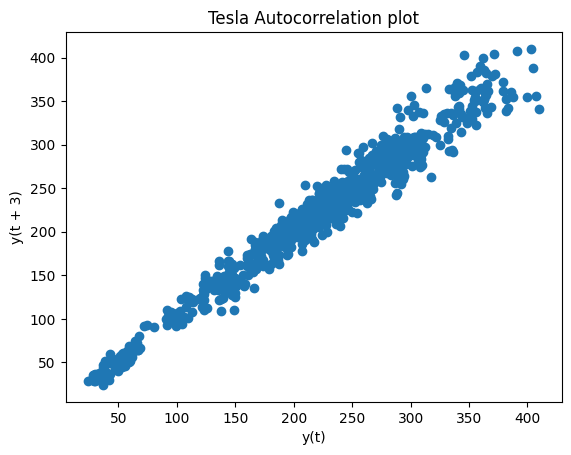

In [96]:
plt.figure()
lag_plot(data['Close'], lag=3)
plt.title('Tesla Autocorrelation plot')
plt.show()

### Looks like our data has a strong correlation between the close price as time 't+3' to its past close price at time 't' 
### Thats a good news for our Arima model

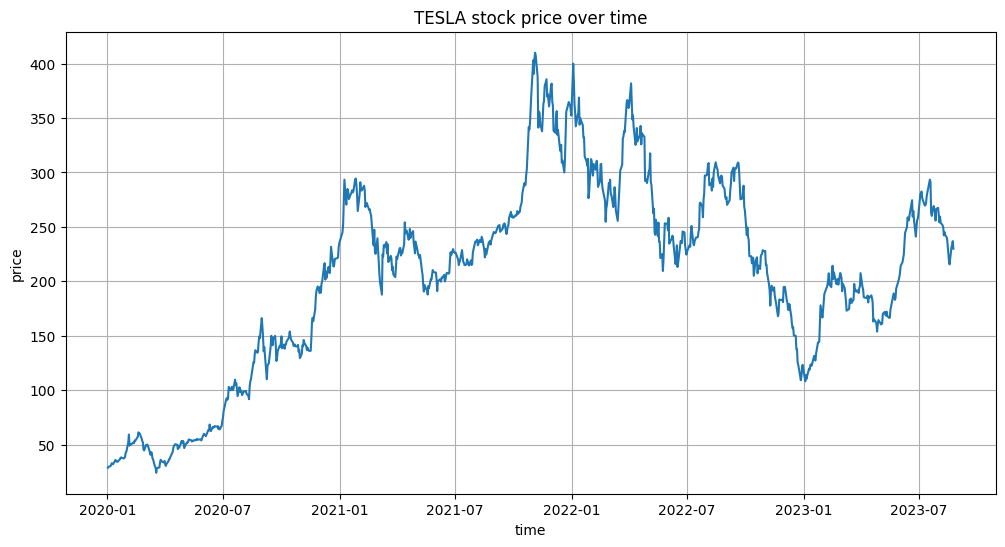

In [97]:
plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Close"])
plt.title("TESLA stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.grid()
plt.show()

# Arima Model Trainning

In [115]:
data

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500
2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500
2020-01-06,30.10,29.36,30.10,29.33,30.10,151995000
2020-01-07,31.27,30.76,31.44,30.22,31.27,268231500
2020-01-08,32.81,31.58,33.23,31.22,32.81,467164500
...,...,...,...,...,...,...
2023-08-18,215.49,214.12,217.58,212.36,215.49,135813700
2023-08-21,231.28,221.55,232.13,220.58,231.28,135702700
2023-08-22,233.19,240.25,240.82,229.55,233.19,130597900


In [ ]:
data = data.set_index("Date")

In [116]:
data['Mean'] = (data['Low'] + data['High'])/2
data.head(2)

,Adj Close,Open,High,Low,Close,Volume,Mean
Date,,,,,,,
2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500,28.41
2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500,29.70


In [117]:
steps=-1
data['Actual']=data['Mean'].shift(steps)
data.head(3)

,Adj Close,Open,High,Low,Close,Volume,Mean,Actual
Date,,,,,,,,
2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500,28.410,29.700
2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500,29.700,29.715
2020-01-06,30.10,29.36,30.10,29.33,30.10,151995000,29.715,30.830


In [118]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(data[['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']])
scaled_input =pd.DataFrame(scaled_input)
X = scaled_input

In [119]:
X.set_index(data.index, inplace=True)

In [120]:
X

,0,1,2,3,4,5
Date,,,,,,
2020-01-02,0.011920,0.008590,0.004439,0.012399,0.011920,0.128385
2020-01-03,0.014123,0.011359,0.008464,0.015067,0.014123,0.268205
2020-01-06,0.015600,0.011333,0.008026,0.015590,0.015600,0.138573
2020-01-07,0.018632,0.014955,0.011484,0.017918,0.018632,0.269962
2020-01-08,0.022623,0.017077,0.016103,0.020534,0.022623,0.494826
...,...,...,...,...,...,...
2023-08-18,0.496022,0.489379,0.491832,0.494350,0.496022,0.120283
2023-08-21,0.536941,0.508603,0.529380,0.515851,0.536941,0.120157
2023-08-22,0.541890,0.556987,0.551805,0.539315,0.541890,0.114387


In [121]:
X.rename(columns={0:'Adj Close', 1:'High', 2:'Low', 3:'Close', 4:'Open'}, inplace=True)
X.head(2)

,Adj Close,High,Low,Close,Open,5
Date,,,,,,
2020-01-02,0.011920,0.008590,0.004439,0.012399,0.011920,0.128385
2020-01-03,0.014123,0.011359,0.008464,0.015067,0.014123,0.268205


In [122]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(data[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [125]:
y.dropna(inplace=True)

In [127]:
train_size=int(len(data) *0.7)
test_size = int(len(data)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

# Params Evaluatioan
### we need to know the AR and MA terms to correct any autocorrelation in the differenced series.
#### ACF plot: is a bar chart of the coefficients of correlation between a time series and its lags. It helps determine the value of p or the AR term.

#### PACF plot: a plot of the partial correlation coefficients between the series and lags of itself. Helps determine the value of q or the MA term

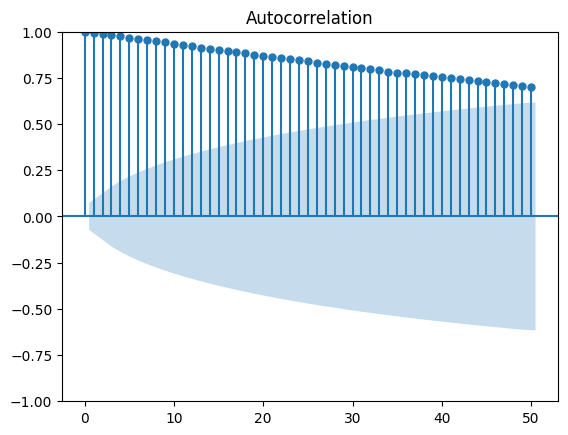

In [45]:
acf = sm.graphics.tsa.plot_acf(train, lags=50)
acf.show()

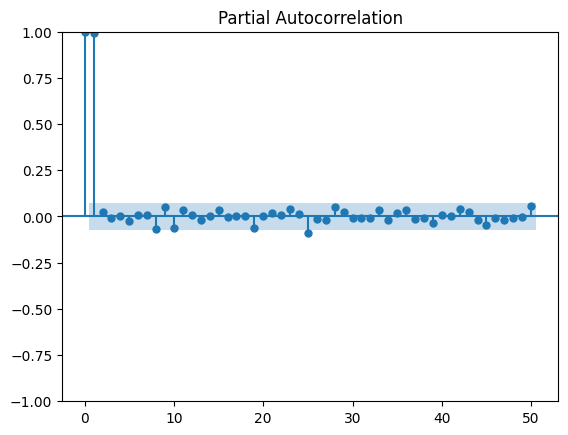

In [42]:
acf = sm.graphics.tsa.plot_pacf(train, lags=50)
acf.show()

In [129]:
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3244.828, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3209.368, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3241.810, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3246.745, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3209.884, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3244.874, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3242.817, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3247.706, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3245.236, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3245.814, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3242.842, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3243.808, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.738 seconds


In [130]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  642
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1625.853
Date:                Thu, 24 Aug 2023   AIC                          -3247.706
Time:                        18:24:33   BIC                          -3238.780
Sample:                             0   HQIC                         -3244.242
                                - 642                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2543      0.030      8.467      0.000       0.195       0.313
sigma2         0.0004   1.44e-05     25.379      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               112.30
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               6.42   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [209]:
tsla = StockData(symbol='TSLA', start_date="2020-01-01", end_date="2024-01-01")
data = tsla.get_historical_symbol_data().reset_index()
data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Adj Close,Open,High,Low,Close,Volume
0,2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500
1,2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500
2,2020-01-06,30.10,29.36,30.10,29.33,30.10,151995000
3,2020-01-07,31.27,30.76,31.44,30.22,31.27,268231500
4,2020-01-08,32.81,31.58,33.23,31.22,32.81,467164500


In [210]:
data.shape

(918, 7)

In [211]:
data['Date'] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
data = data["Close"].to_frame()

In [212]:
data

,Close
Date,
2020-01-02,28.68
2020-01-03,29.53
2020-01-06,30.10
2020-01-07,31.27
2020-01-08,32.81
...,...
2023-08-18,215.49
2023-08-21,231.28
2023-08-22,233.19


In [235]:
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

X = data.values
size = int(len(X)*0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [236]:
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)

In [237]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error (MSE): 51.038561026007635
Mean Absolute Error (MAE): 5.516816758008528
R2 Score: 0.9755872672336774


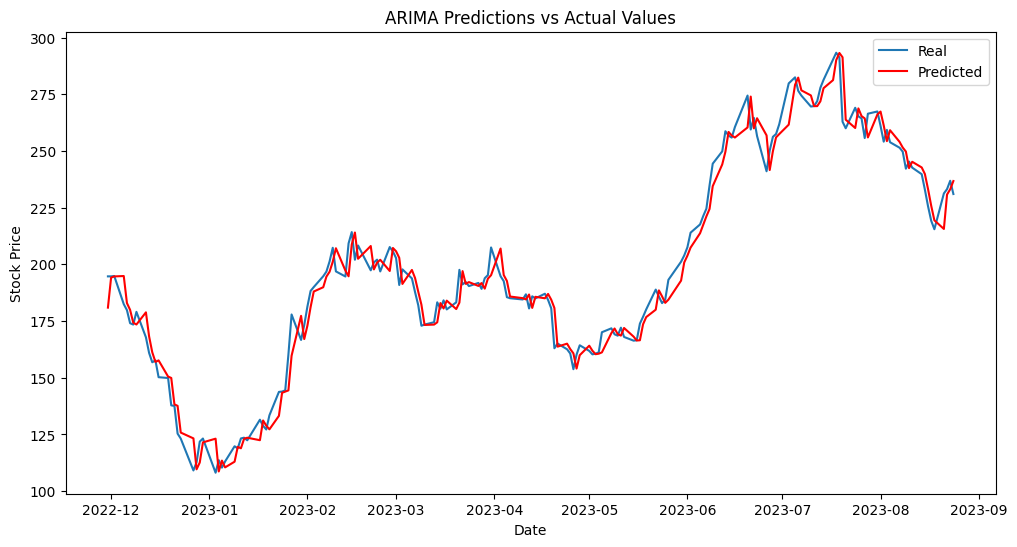

In [238]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(data.iloc[size:,:].index, test, label='Real')
plt.plot(data.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Learning Objective 2: LSTM

In [243]:
tsla = StockData(symbol='TSLA', start_date="2020-01-01", end_date="2023-12-31")
data = tsla.get_historical_symbol_data()
data.head()


[*********************100%%**********************]  1 of 1 completed


,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500
2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500
2020-01-06,30.10,29.36,30.10,29.33,30.10,151995000
2020-01-07,31.27,30.76,31.44,30.22,31.27,268231500
2020-01-08,32.81,31.58,33.23,31.22,32.81,467164500


In [244]:
def ts_train_test_normalize(all_data,time_steps,for_periods):

    # create training and test set
    ts_train = all_data[:'2022'].iloc[:,0:1].values
    ts_test  = all_data['2022':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2022'], all_data["Adj Close"]['2022':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [135]:
X_train, y_train, X_test, sc = ts_train_test_normalize(data,5,2)

In [136]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = data.loc['2022':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )

13/13 [==============================] - 0s 1ms/step


(723.15155, <Axes: xlabel='Date'>)

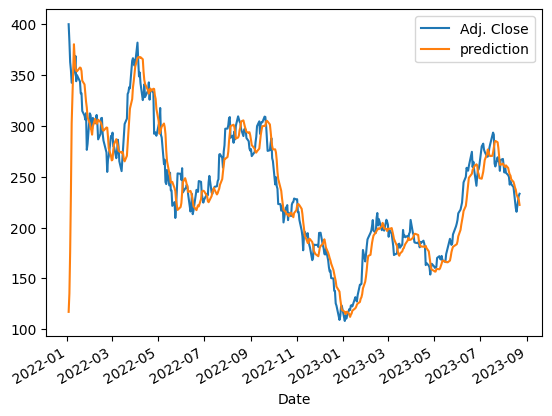

In [137]:

def LSTM_model(X_train, y_train, X_test, sc):
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='adam',loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)   

# Learning Objective 3: SARIMA

In [20]:
tsla = StockData(symbol='TSLA', start_date="2020-01-01", end_date="2023-7-31")
data = tsla.get_historical_symbol_data()
data.head()

[*********************100%%**********************]  1 of 1 completed


,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2020-01-02,28.68,28.30,28.71,28.11,28.68,142981500
2020-01-03,29.53,29.37,30.27,29.13,29.53,266677500
2020-01-06,30.10,29.36,30.10,29.33,30.10,151995000
2020-01-07,31.27,30.76,31.44,30.22,31.27,268231500
2020-01-08,32.81,31.58,33.23,31.22,32.81,467164500


In [21]:
# Resample the data to the monthly level
monthly_mean = data['Adj Close'].resample('M').mean()

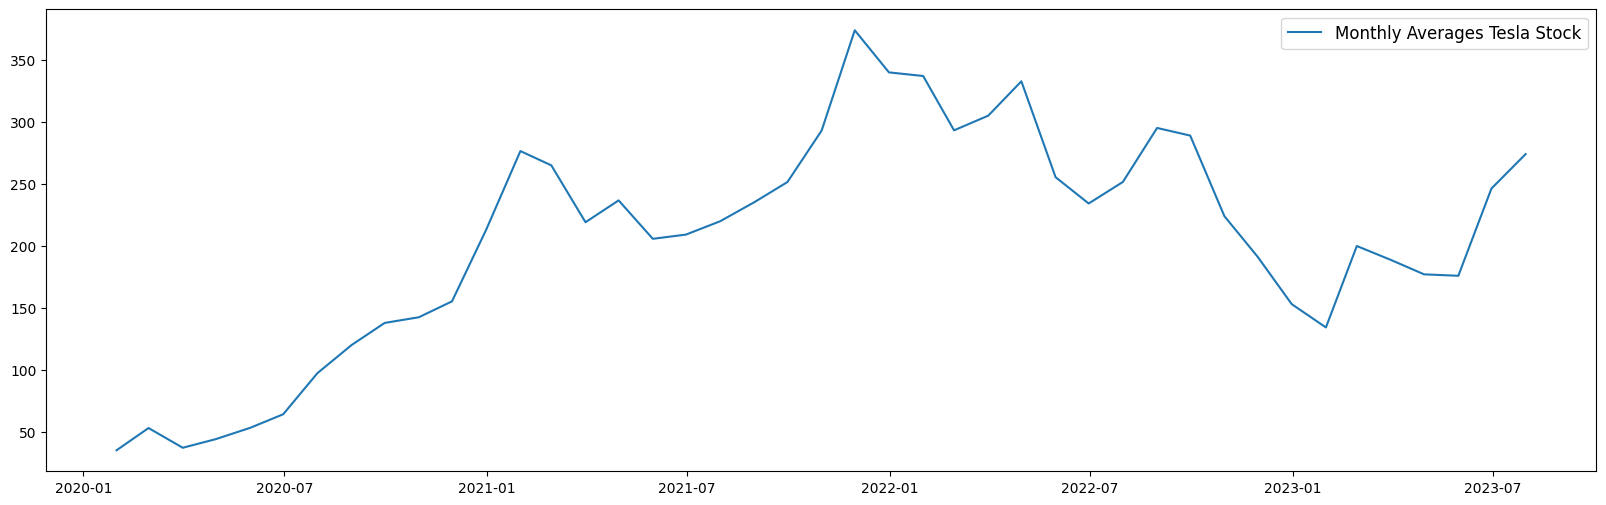

In [22]:
monthly_data = monthly_mean.to_frame()
##Monthly Stock Price 
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['Adj Close'],label='Monthly Averages Tesla Stock')
plt.legend(prop={'size': 12})
plt.show()

# Decomposition of Time Series

<Figure size 2000x1200 with 0 Axes>

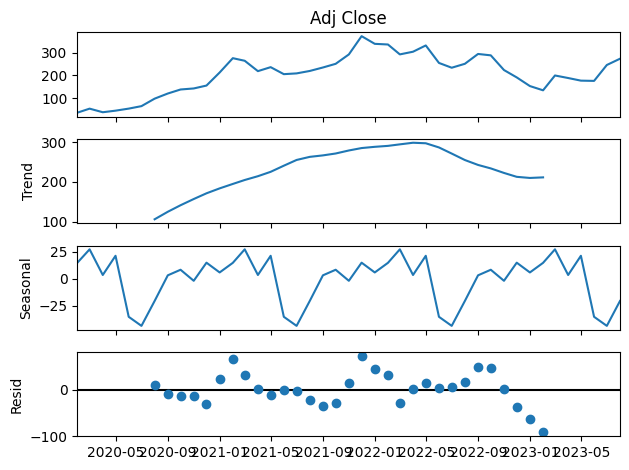

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

plt.figure(figsize=(20,12))
decomposed_series = sd(monthly_data['Adj Close'])
decomposed_series.plot()
plt.show()

## Inferences:
### Trend : Overall an Upward Trend
### Seasonality :There appears to be seasonality. 
### TESLA has rallied during the Holiday season as expected. Since Holiday period has good sales for Apple Over the Years.

<Axes: xlabel='Date'>

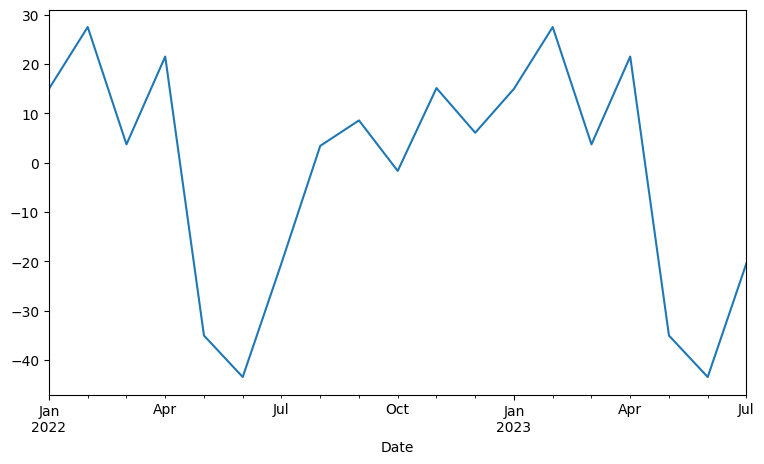

In [24]:
fig = plt.figure(figsize=(9,5))
decomposed_series.seasonal['2022':'2023'].plot()

In [25]:
from statsmodels.tsa.stattools import adfuller

def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
   print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis- Time Series is Stationary')
  else:
    print('Failed to Reject Null Hypothesis- Time Series is Non-Stationary')

ad_fuller_func(monthly_data['Adj Close'])

ADF Statistic: -2.031289
p-value: 0.273025
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606
Failed to Reject Null Hypothesis- Time Series is Non-Stationary


# Transformation to make series stationary
### We will use First Order Differencing to detrend the series

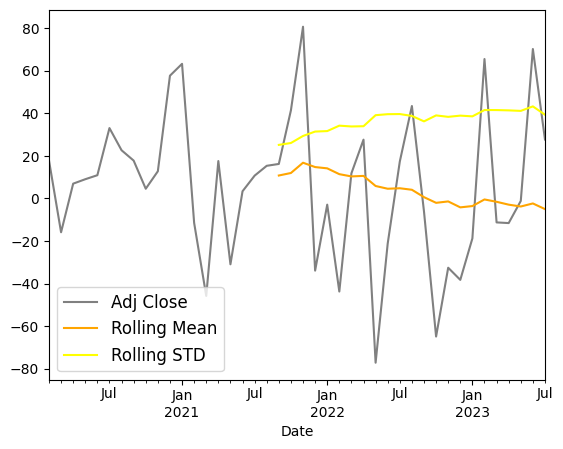

In [26]:
monthly_diff = monthly_data['Adj Close'] - monthly_data['Adj Close'].shift(1)
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [27]:
ad_fuller_func(monthly_diff[1:])

ADF Statistic: -5.209608
p-value: 0.000008
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606
Reject Null Hypothesis- Time Series is Stationary


# Observation
The series looks stationary as its having constant mean and variance

# SARIMA
### P: Seasonal autoregressive order.
### D: Seasonal difference order.
### Q: Seasonal moving average order.
### m: The number of time steps for a single seasonal period.

Observations: 362
Training Observations: 183
Testing Observations: 179
Observations: 541
Training Observations: 362
Testing Observations: 179
Observations: 720
Training Observations: 541
Testing Observations: 179
Observations: 899
Training Observations: 720
Testing Observations: 179


<Figure size 640x480 with 0 Axes>

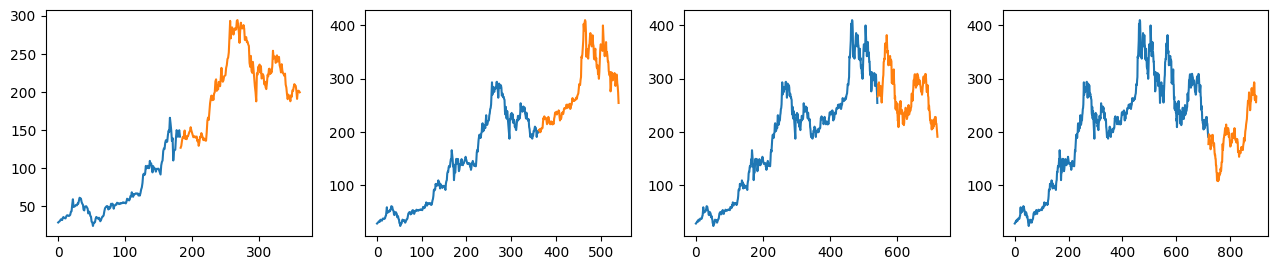

In [28]:
time_series_splits = TimeSeriesSplit(n_splits=4)
X = data["Adj Close"].values
plt.figure(1)
fig = plt.figure(figsize=(24, 10))

index = 1
for train_index, test_index in time_series_splits.split(X):
 train = X[train_index]
 test = X[test_index]
 print('Observations: %d' % (len(train) + len(test)))
 print('Training Observations: %d' % (len(train)))
 print('Testing Observations: %d' % (len(test)))
    
 plt.subplot(360 + index)
 plt.plot(train)
 plt.plot([None for i in train] + [x for x in test])
    # pyplot.title(''.format())
 index += 1
plt.show();

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13798D+00    |proj g|=  2.32168D+00

At iterate    5    f=  4.03825D+00    |proj g|=  2.85166D-02

At iterate   10    f=  3.88637D+00    |proj g|=  1.58916D-03

At iterate   15    f=  3.88201D+00    |proj g|=  4.44802D-02

At iterate   20    f=  3.87561D+00    |proj g|=  2.23684D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     36      1     0     0   5.559D-06   3.876D+00
  F =   3.8756055692541471     

CONVERG

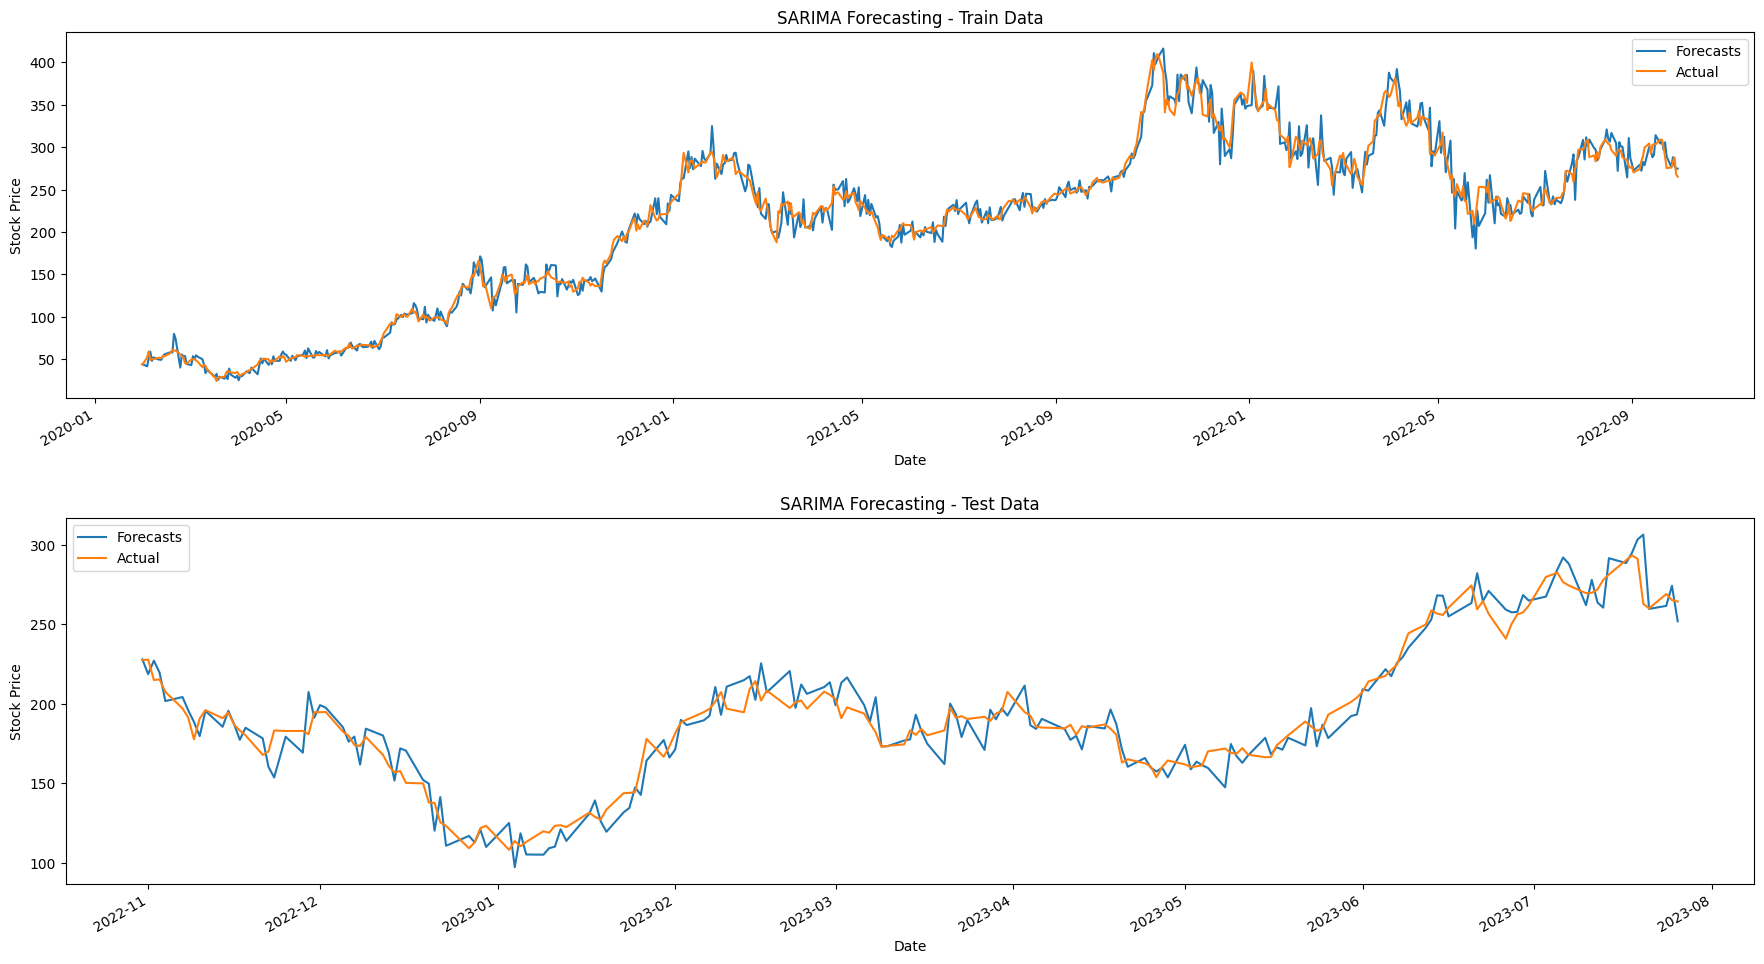

In [32]:
modelling_series = data["Adj Close"]
modelling_series.index = pd.to_datetime(modelling_series.index)

# SARIMA model
model = sm.tsa.SARIMAX(modelling_series, order=(0,1,1), seasonal_order=(2,2,0,12))
results = model.fit()

# Define date ranges
sd = '2020-01-31'
ed = '2022-09-30'
sd2 = '2022-10-31'
ed2 = '2023-7-26'

# Make predictions
forecasts_train = results.predict(start=pd.to_datetime(sd), end=pd.to_datetime(ed))
forecasts_test = results.predict(start=pd.to_datetime(sd2), end=pd.to_datetime(ed2))

# Plotting
fig, (ax1, ax2) = plt.subplots(2, figsize=(18, 10))

forecasts_train.plot(label='Forecasts', ax=ax1, title='SARIMA Forecasting - Train Data')
modelling_series.loc[sd:ed].plot(label='Actual', ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts', ax=ax2, title='SARIMA Forecasting - Test Data')
modelling_series.loc[sd2:ed2].plot(label='Actual', ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)
plt.show()